In [11]:
from scipy.fftpack import dct
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile

In [3]:
# 关于一些图像的绘制函数
def plot_time(sig, fs,png_name):
    """
    绘制时域图
    """
    time = np.arange(0, len(sig)) * (1.0 / fs)
    plt.figure(figsize=(10, 5))
    plt.plot(time, sig)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.savefig(png_name)
    plt.show()

def plot_freq(sig, sample_rate, png_name,nfft=512):
    """
    绘制频域图
    """
    xf = np.fft.rfft(sig, nfft) / nfft
    freqs = np.linspace(0, int(sample_rate/2), int(nfft/2 + 1))
    xfp = 20 * np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, xfp)
    plt.xlabel('Freq(hz)')
    plt.ylabel('dB')
    plt.grid()
    plt.savefig(png_name)
    plt.show()

def plot_spectrogram(spec, ylabel,png_name):
    """
    绘制二维数组
    """
    fig = plt.figure(figsize=(10, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Frame(s)')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(png_name)
    plt.show()

In [12]:
# step 1: 读入语音
sample_rate, signal = wavfile.read('./speech_feature/wav/我爱南开.wav')

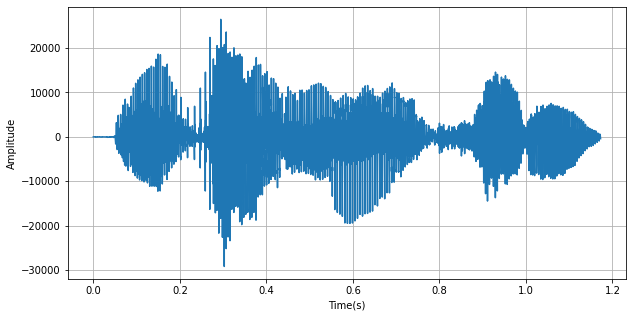

In [13]:
plot_time(signal, sample_rate, "时域图")

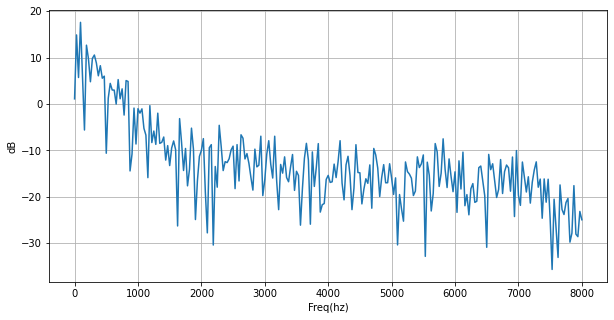

In [14]:
plot_freq(signal, sample_rate, "频谱图")

In [15]:
# step2: 预加重
def pre_emphasis(sig):
    """
    function:预加重
    para: sig:要进行处理的音频数据
    return 进行加强处理后的音频数据
    """
    preemphasis=0.97
    # sig=np.append(sig[0],sig[1:]-np.array([preemphasis])*sig[:-1])
    sig=np.append(sig[0],sig[1:]-preemphasis*sig[:-1])
    return sig

In [16]:
signal = pre_emphasis(signal)

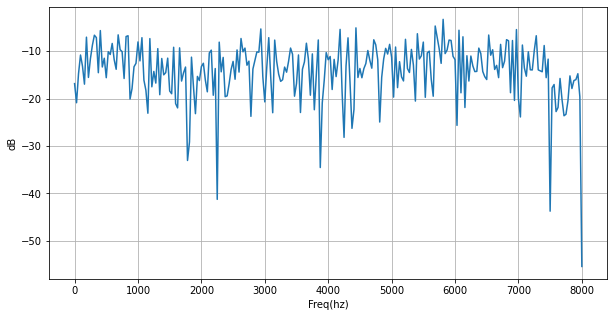

In [17]:
plot_freq(signal, sample_rate, "频谱图2")

In [18]:
# step 3: 分帧
def framing(sig,fs,frame_len_s=0.025,frame_shift_s=0.01):
    """
    function：分帧
    para：
        frame_len_s:每一帧的长度,单位为s
        frame_shift_s:分帧的shift,单位为s
        fs：采样率，hz
        sig：要进行分帧的音频信号
    return：进行分帧后的数据，一个二维list，一个元素是一帧信号
    """
    sig_n=len(sig)
    frame_len_n=int(round(fs*frame_len_s))
    frame_shift_n=int(round(fs*frame_shift_s))
    num_frame=int(np.ceil(float(sig_n-frame_len_n)/frame_shift_n)+1) 
    pad_num=frame_shift_n*(num_frame-1)+frame_len_n-sig_n # 待补0的个数
    # 一种前后向拼接array的方法-------------
    pad_zero=np.zeros(int(pad_num)) 
    pad_sig=np.append(sig,pad_zero) 
    #-------------------------------------
    # 计算下标：
    frame_inner_index=np.arange(0,frame_len_n)
    # 分帧后每个帧的起始下标：
    frame_index=np.arange(0,num_frame)*frame_shift_n    
    # 在行方向上复制每个帧的内部下标：
    frame_inner_index_extend=np.tile(frame_inner_index,(num_frame,1))
    # 各帧起始下标扩展维度，便于后续相加：
    frame_index_extend=np.expand_dims(frame_index,1)
    # 分帧后各帧下标：
    each_frame_index=frame_inner_index_extend+frame_index_extend
    each_frame_index=each_frame_index.astype(np.int,copy=False)
    frame_sig=pad_sig[each_frame_index]
    return frame_sig

In [20]:
frame_sig = framing(signal, sample_rate)

C:\Users\xiaoduo\AppData\Local\Temp\ipykernel_7316\1264449809.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  each_frame_index=each_frame_index.astype(np.int,copy=False)


In [21]:
# step 4: 加窗
def add_window(frame_sig,fs,frame_len_s=0.025):
    """
    function：加窗
    para：
        frame_len_s：每一帧的长度,单位为s
        fs：采样率
        frame_sig:进行分帧后的数据
    return：加窗后的数据
    """
    window=np.hamming(int(round(frame_len_s*fs)))
    frame_sig*=window
    return frame_sig

In [22]:
frame_sig = add_window(frame_sig, sample_rate)

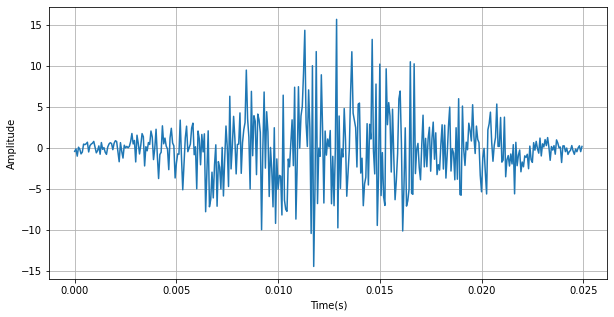

In [24]:
plot_time(frame_sig[1], sample_rate, "时域图2")

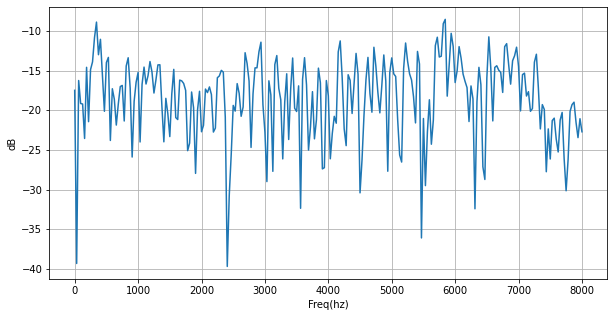

In [25]:
plot_freq(frame_sig[1], sample_rate, "频谱图3")

In [26]:
# step 5: 快速傅里叶变换
def my_fft(frame_sig):
    """
    function：傅里叶变换
    para:frame_sig：进行加窗处理后的数据
    return：进行傅里叶变换后的数据
    """
    NFFT=512 # NFFT常为256或512
    mag_frames = np.absolute(np.fft.rfft(frame_sig, NFFT)) 
    return mag_frames   

In [27]:
mag_frames = my_fft(frame_sig)

In [28]:
def stft(frame_sig, nfft=512):    
    """
    function：短时傅里叶变换将帧信号变为帧功率（对应幅值频发）
    para：
        frame_sig: 分帧后的信号
        nfft: fft点数
    return: 返回分帧信号的功率谱
    """
    frame_spec = np.fft.rfft(frame_sig, nfft)
    """
    np.fft.fft vs np.fft.rfft
    fft 返回 nfft
    rfft 返回 nfft // 2 + 1，即rfft仅返回有效部分
    """
    # 幅度谱
    frame_mag = np.abs(frame_spec) # 语音信号频谱取模
    # 功率谱
    frame_pow = (frame_mag ** 2) * 1.0 / nfft # 取平方 
    return frame_pow

In [29]:
# step 6: 幅值平方, 变为功率谱
frame_pow = stft(frame_sig)

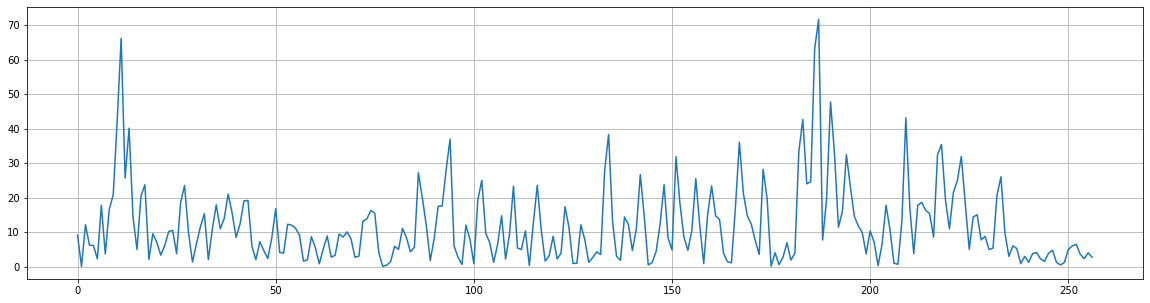

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(frame_pow[1])
plt.grid()

In [31]:
# step 7: mel滤波器
def mel_filter(frame_pow, fs, n_filter=80, nfft=512):    
    """
    function:mel 滤波器系数计算
    para:
        frame_pow: 分帧信号功率谱
        fs: 采样率 hz
        n_filter: 滤波器个数
        nfft: fft点数
    return: 分帧信号功率谱mel滤波后的值的对数值
    mel = 2595 * log10(1 + f/700) # 频率到mel值映射
    f = 700 * (10^(m/2595) - 1 # mel值到频率映射
    上述过程本质上是对频率f对数化
    """
    mel_min = 0 # 最低mel值
    mel_max = 2595 * np.log10(1 + fs / 2.0 / 700) # 最高mel值，最大信号频率为 fs/2
    mel_points = np.linspace(mel_min, mel_max, n_filter + 2) # n_filter个mel值均匀分布与最低与最高mel值之间
    hz_points = 700 * (10 ** (mel_points / 2595.0) - 1) # mel值对应回频率点，频率间隔指数化
    filter_edge = np.floor(hz_points * (nfft + 1) / fs) # 对应到fft的点数比例上
    # 求mel滤波器系数
    fbank = np.zeros((n_filter, int(nfft / 2 + 1)))
    for m in range(1, 1 + n_filter):
        f_left = int(filter_edge[m - 1]) # 左边界点
        f_center = int(filter_edge[m]) # 中心点
        f_right = int(filter_edge[m + 1]) # 右边界点
        for k in range(f_left, f_center):
            fbank[m - 1, k] = (k - f_left) / (f_center - f_left)
        for k in range(f_center, f_right):
            fbank[m - 1, k] = (f_right - k) / (f_right - f_center)
    # mel 滤波
    # [num_frame, nfft/2 + 1] * [nfft/2 + 1, n_filter] = [num_frame, n_filter]
    filter_banks = np.dot(frame_pow, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    # np.finfo函数是根据括号中的类型来获得信息，获得符合这个类型的数型, eps是取非负的最小值
    return filter_banks

In [32]:
filter_banks = mel_filter(frame_pow, sample_rate)

In [33]:
print(filter_banks)

[[1.74039184e+00 4.32629112e+00 2.22044605e-16 ... 9.22062712e+01
  5.49368953e+01 1.81565736e+01]
 [9.12617424e+00 5.97816506e-02 2.22044605e-16 ... 8.64974828e+01
  3.53930822e+01 2.61129397e+01]
 [7.50510795e+01 6.83523484e+01 2.22044605e-16 ... 1.12316166e+02
  8.02835375e+01 2.39443681e+01]
 ...
 [8.96432335e-02 4.70119330e+01 2.22044605e-16 ... 2.42657713e+03
  1.35966185e+03 9.02380090e+02]
 [1.56987017e+00 2.39635216e+00 2.22044605e-16 ... 2.12341933e+03
  1.70619018e+03 1.45056787e+03]
 [1.16828972e+00 1.90581785e+01 2.22044605e-16 ... 1.13253247e+03
  7.38057254e+02 4.07467432e+02]]


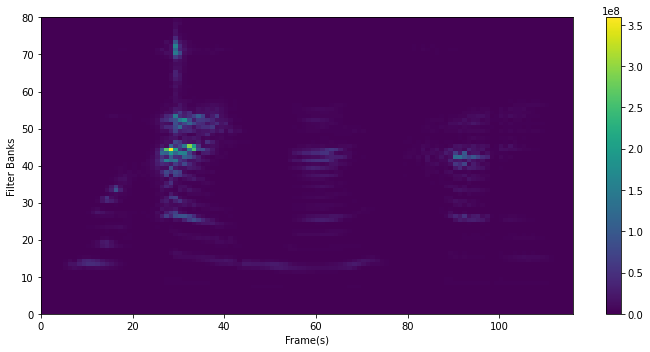

In [37]:
plot_spectrogram(filter_banks.T, "Filter Banks", "mel图")

In [38]:
# step 8: 对数功率
def log_pow(filter_banks):
    """
    function：功率取对数
    para：filter_banks:经过mel滤波器的数据
    return：取对数后的功率数据，即fbank
    """
    # 取对数 (功率取对数)
    filter_banks = 20 * np.log10(filter_banks) # dB
    return filter_banks

In [39]:
filter_banks = log_pow(filter_banks)

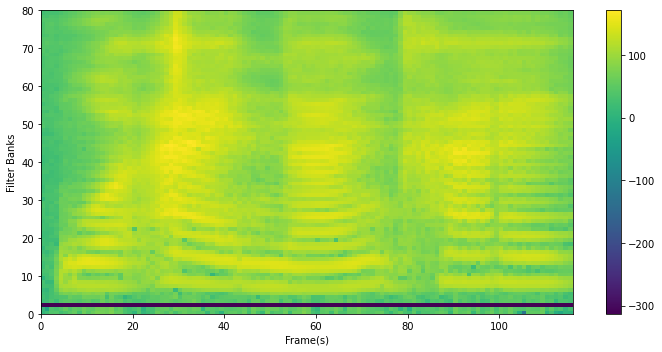

In [40]:
plot_spectrogram(filter_banks.T, "Filter Banks", "mel图2")

In [41]:
# spectrogram特征抽取, 并可视化
spec = log_pow(frame_pow)

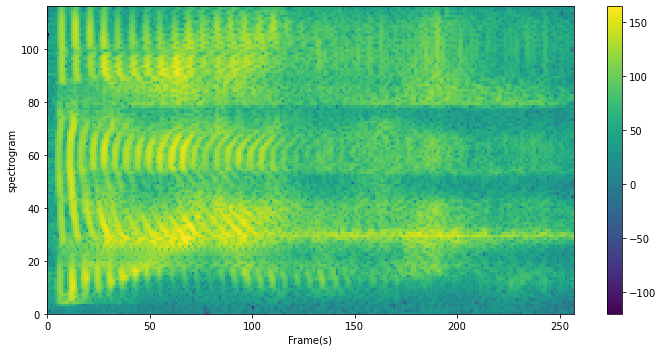

In [42]:
plot_spectrogram(spec, "spectrogram", "spectiogram可视化")

In [43]:
# MFCC特征，并可视化
def discrete_cosine_transform(filter_banks):
    """
    function：离散余弦变换
    para：filter_banks:fbanks
    return: mfcc
    """
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps+1)] # 保持在2-13
    """
    scipy.fftpack.dct:返回任意类型序列x的离散余弦变换。
    """
    return mfcc

In [44]:
mfcc = discrete_cosine_transform(filter_banks)

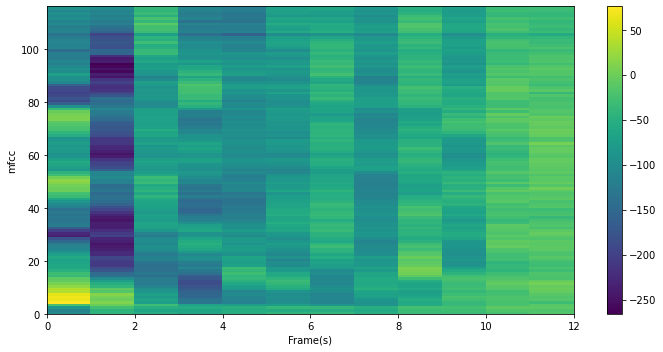

In [45]:
plot_spectrogram(mfcc, "mfcc", "mfcc可视化")

In [ ]:
# PLP特征，并可视化
